# MIMO for Event History

In [1]:
import numpy as np
import mdof
import quakeio
from mdof import modal, transform
from mdof.utilities import Config, extract_channels, print_modes

## Data inputs

In [2]:
# PAINTER RIO DELL TRANSVERSE (CASE 1)
station_id = 'CE89324'
chan_config_direction = 'Transverse'

In [3]:
directory = f"uploads/{station_id}/"
pattern  = "????????*.[zZ][iI][pP]"
from pathlib import Path
files = [file for file in Path(directory).glob(pattern)]

In [4]:
from uploads.channel_conf import CHANNEL_CONF
chan_conf = CHANNEL_CONF[station_id][chan_config_direction]
chan_conf

{'inputs': [3, 17, 20], 'outputs': [7, 9, 4]}

## Method Inputs

### General Parameters
parameter | value
----------|-------
`p ` | number of output channels
`q ` | number of input channels
`nt` | number of timesteps
`dt` | timestep
`decimation`  | decimation (downsampling) factor
`order` | model order (2 times number of DOF)

### Observer Kalman Identification (OKID)
parameter | value
----------|-------
`m`  | number of Markov parameters to compute (at most = nt)

### Eigensystem Realization Algorithm (ERA)
parameter | value
----------|-------
`horizon` | number of observability parameters, or prediction horizon
`nc` | number of controllability parameters

### System Realization with Information Matrix (SRIM)
parameter | value
----------|-------
`horizon` | number of steps used for identification, or prediction horizon

### Parameters for Mode Validation
parameter | value
----------|-------
`outlook` | number of steps used for temporal consistency in EMAC

In [5]:
# Set Parameters
conf = Config()
conf.m  = 500
conf.horizon = 190
conf.nc = 190
conf.order  = 12
conf.a  = 0  
conf.b  = 0  
conf.l  = 10 
conf.g  = 3
conf.period_band = (0.1,0.6)
conf.damping = 0.06
conf.pseudo = True
conf.outlook = 190
# conf.ss_decimation = 8

uploads/CE89324/RioDell_14Sep2012_71842255_ce89324p.zip
peak acceleration (cm/s/s): 0.07422310371023538
event date/time: 2012-09-14T18:19:00
okid-era
Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC
      0.2884     -0.0222    1.0        0.2057     0.2057   
      0.2535     -0.07056   1.0        0.9278     0.9278   
      0.2169     0.02866    1.0        0.8527     0.8527   
      0.1441     0.02229    1.0        0.7275     0.7275   
      0.1211     -0.006544  1.0        0.9409     0.9409   
      0.1042     -0.006533  1.0        0.4507     0.4507   
Mean Period(s): 0.188027027684772
Standard Dev(s): 0.06908592345454602
srim
Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC
      0.2778     0.0308     1.0        0.9286     0.9286   
      0.2615     0.04845    1.0        0.365      0.365    
      0.2265     0.01969    1.0        0.966      0.966    
      0.2134     0.03212    1.0        0.9523     0.9523   
      0.1966  

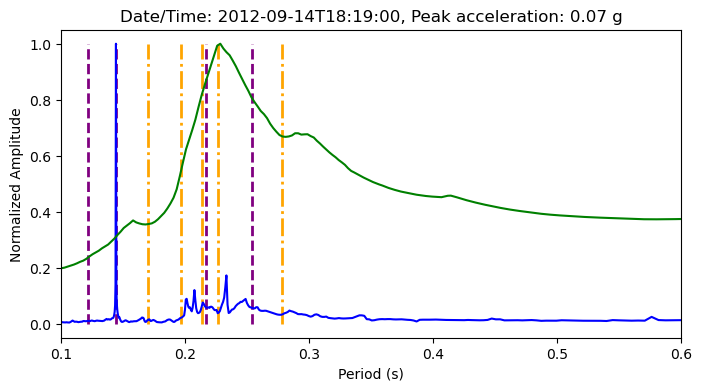

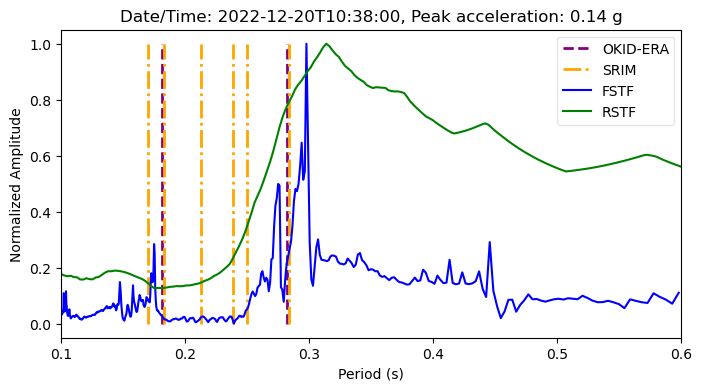

In [6]:
event_modes = []
from matplotlib import pyplot as plt

methods = ["okid-era", "srim"]
lstyles = ["dashed", "dashdot", "dotted"]
colors = ["purple", "orange", "black"]
realizations = {}
summary_table = {}

for i, file in enumerate(files[:2]):
    fig, ax = plt.subplots(figsize=(8,4))
    print(file)
    try:
        event = quakeio.read(file, exclusions=["*filter*"])#, "*date*"])
        peak_accel = np.abs(event['peak_accel']*0.0010197162129779)
        event_date = event['event_date']
        print("peak acceleration (cm/s/s):", peak_accel)
        print("event date/time:", event_date)
        inputs, dt = extract_channels(event, chan_conf['inputs'])
        outpts, dt = extract_channels(event, chan_conf['outputs'])
        summary_table[event_date] = {"peak acc": np.round((peak_accel),3)}
        for method in methods:
            realizations[method] = mdof.system(method=method, inputs=inputs, outputs=outpts, threads=8, chunk=200, **conf)
    except Exception as e:
        print(e)
        print(">>>>> Not read: ", file.name)
        continue
    for j,method in enumerate(methods):
        print(method)
        ss_modes = modal.system_modes(realizations[method],dt,**conf)
        ss_periods = [1/value["freq"] for value in ss_modes.values() if value["energy_condensed_emaco"]>0.5 and value["mpc"]>0.5]
        ax.vlines(ss_periods, 0, 1, linestyles=lstyles[j], color=colors[j], linewidth=2, label=f"{method.upper()}")# if i==0 else None)
        summary_table[event_date][method] = np.round(np.max(ss_periods),3) if len(ss_periods)>0 else np.nan
        print_modes(ss_modes)
    periods, amplitudes = transform.fourier_transfer(inputs=inputs[0], outputs=outpts[0], step=dt, **conf)
    amplitudes = amplitudes/max(amplitudes)
    summary_table[event_date]['FSTF'] = np.round(modal.spectrum_modes(periods, amplitudes, prominence=0.1)[0][0],3)
    ax.plot(periods, amplitudes, label="FSTF", color="blue")
    periods, amplitudes = transform.response_transfer(inputs=inputs[0], outputs=outpts[0], step=dt, periods=periods, threads=8, **conf)
    amplitudes = amplitudes/max(amplitudes)
    summary_table[event_date]['RSTF'] = np.round(modal.spectrum_modes(periods, amplitudes, prominence=0.1)[0][0],3) if len(modal.spectrum_modes(periods, amplitudes)[0]) > 0 else np.nan
    ax.plot(periods, amplitudes, label="RSTF", color="green")
    ax.set_xlim(conf.period_band)
    ax.set_title(f"Date/Time: {event_date}, Peak acceleration: {np.round(peak_accel,2)} g")
    ax.set_xlabel("Period (s)")
    ax.set_ylabel("Normalized Amplitude")
    if i==1:
        ax.legend(loc='upper right', frameon=True, framealpha=0.5)

In [7]:
import pandas as pd
pd.DataFrame(summary_table).T

,peak acc,okid-era,srim,FSTF,RSTF
2012-09-14T18:19:00,0.074,0.253,0.278,0.233,0.228
2022-12-20T10:38:00,0.143,0.282,0.284,0.445,0.314
